https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset/data

In [1]:
from glob import glob 

image_paths = []
labels_str = []

for g in glob('./data/garbage_images/*'):
    for img_path in glob(g+'/*'):
        image_paths.append(img_path)
        labels_str.append(g.split('/')[-1])
        
print(len(image_paths), len(labels_str))
print(labels_str[:5])

2527 2527
['paper', 'paper', 'paper', 'paper', 'paper']


In [2]:
# str 형태의 label을 int로 변환
label_dict = {i: s for i, s in enumerate(set(labels_str))}
label_dict

{0: 'plastic', 1: 'trash', 2: 'glass', 3: 'paper', 4: 'metal', 5: 'cardboard'}

In [3]:
# 각 유형별로 이미지 수 확인
from collections import Counter
counts = Counter(labels_str)

print(counts)

print(counts.keys())
print(counts.values())

Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})
dict_keys(['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic'])
dict_values([594, 410, 403, 137, 501, 482])


In [4]:
label = [list(label_dict.keys())[list(label_dict.values()).index(l)] for l in labels_str]

print(label[:5])

[3, 3, 3, 3, 3]


In [5]:
# 8:2 비율로 train, test 데이터 분리, 클래스 불균형을 고려하여 stratify 적용

from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, label, test_size=0.2, stratify=label, random_state=42, shuffle=True)
print(len(train_paths), len(test_paths))


# label 별로 이미지 수 확인
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print(train_counts)
print(test_counts)

2021 506
Counter({3: 475, 2: 401, 0: 385, 4: 328, 5: 322, 1: 110})
Counter({3: 119, 2: 100, 0: 97, 4: 82, 5: 81, 1: 27})


In [6]:
# 이미지 크기가 뭐뭐 있는지 확인

from PIL import Image

shapes = set()


for img_path in image_paths:
    img = Image.open(img_path)
    
    
    shapes.add(f'{img.size} {len(img.split())}')
    
    
print(shapes)

# 다행히 이미지 크기가 다 같음

{'(512, 384) 3'}


In [7]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


In [8]:
# 이미지 증강

max_image_cnt = 475

def augment_image(image_path, save_to_dir, num_augments=1, image_size=(512, 384)):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
    )

    img = load_img(image_path)  # 이미지 불러오기
    x = img_to_array(img)  # 이미지 -> numpy 배열
    x = x.reshape((1,) + x.shape)  # (1, height, width, channels)

    # 이미지 증강
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= num_augments:
            break
            



In [9]:
# train 이미지 증강
import random

augmented_dir = './data/augmented_images'

if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)
else:
    for g in glob(augmented_dir+'/*'):
        for img_path in glob(g+'/*'):
            os.remove(img_path)
        os.rmdir(g)
    os.rmdir(augmented_dir)
    
for label in set(train_labels):
    label_dir = os.path.join(augmented_dir, label_dict[label])
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        
# 클래스별로 이미지 증강
for class_no, count in train_counts.items():
    class_name = label_dict[class_no]
    while count < max_image_cnt:
        print(f'{class_name} is augmenting')
        
        class_dir = os.path.join(augmented_dir, class_name)
        image_paths = [img_path for img_path, label in zip(train_paths, train_labels) if label == class_no]
        
        num_augments = max_image_cnt - count
        
        for i in range(num_augments):
            img_path = image_paths[random.randint(0, len(image_paths)-1)]
            augment_image(img_path, class_dir, num_augments=1)
            count += 1
    

glass is augmenting
plastic is augmenting
metal is augmenting
cardboard is augmenting
trash is augmenting


In [10]:
# 증강한 이미지도 포함하여 이미지 경로와 레이블을 다시 읽어옴

augmented_image_paths = []
augmented_labels = []

for g in glob(augmented_dir+'/*'):
    label_no = list(label_dict.keys())[list(label_dict.values()).index(g.split('/')[-1])]
    for img_path in glob(g+'/*'):
        augmented_image_paths.append(img_path)
        augmented_labels.append(label_no)
        
print(len(augmented_image_paths), len(augmented_labels))

818 818


In [11]:
train_real_n_aug_paths = train_paths + augmented_image_paths
train_real_n_aug_labels = train_labels + augmented_labels

print(len(train_real_n_aug_paths), len(train_real_n_aug_labels))

# label 별로 이미지 수 확인
train_real_n_aug_counts = Counter(train_real_n_aug_labels)
print(train_real_n_aug_counts)

2839 2839
Counter({2: 475, 3: 475, 4: 474, 5: 474, 0: 473, 1: 468})


In [12]:
# 합성곱 신경망 만들기

model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(256, 256, 3)))
model.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(200, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(tf.keras.layers.Dense(50, activation='relu'))
# model.add(tf.keras.layers.Dense(25, activation='relu')) #*
model.add(tf.keras.layers.Dropout(0.35))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     3,276,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,283,538 (12.53 MB)

 Trainable params: 3,283,538 (12.53 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 이미지 데이터 전처리

train_images = []

for img_path in train_real_n_aug_paths:
    img = Image.open(img_path)
    img = img.resize((256, 256))
    img = np.array(img)
    train_images.append(img)
    
train_images = np.array(train_images)
train_real_n_aug_labels = np.array(train_real_n_aug_labels)

print(train_images.shape)
print(train_images[0].shape)

(2839, 256, 256, 3)
(256, 256, 3)


In [15]:
train_images = train_images / 255.00

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('./models/garbage_model.keras', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


In [17]:
print(train_images.shape)
print(train_real_n_aug_labels)

(2839, 256, 256, 3)
[2 0 4 ... 0 0 0]


In [18]:
history = model.fit(
    train_images, train_real_n_aug_labels, epochs=50, 
    # batch_size=1000, 
    validation_split=0.3, callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.2731 - loss: 1.7493 - val_accuracy: 0.2019 - val_loss: 1.8396
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.4636 - loss: 1.3202 - val_accuracy: 0.3005 - val_loss: 1.7327
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.5626 - loss: 1.1388 - val_accuracy: 0.4049 - val_loss: 1.6661
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.6150 - loss: 1.0537 - val_accuracy: 0.4331 - val_loss: 1.4674
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.6826 - loss: 0.9054 - val_accuracy: 0.3791 - val_loss: 1.8177
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.7123 - loss: 0.7834 - val_accuracy: 0.4871 - val_loss: 1.5074
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.7264 - loss: 0.7426 - val_accuracy: 0.4683 - val_loss: 1.4607
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.7440 - loss: 0.6798 - val_accura

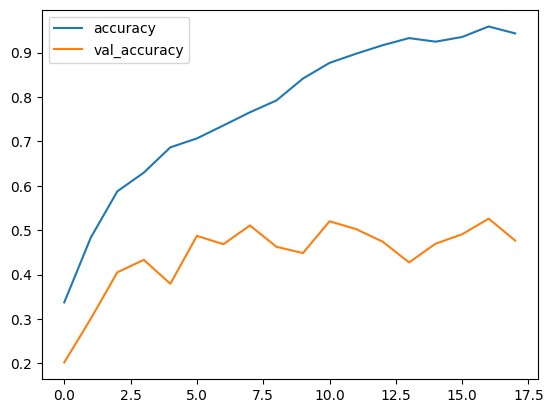

In [19]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.legend()
plt.show()

In [20]:
# test 데이터 전처리

test_images = []

for img_path in test_paths:
    img = Image.open(img_path)
    img = img.resize((256, 256))
    img = np.array(img)
    test_images.append(img)
    
test_images = np.array(test_images)

test_images = test_images / 255.0

test_labels = np.array(test_labels)

model.evaluate(test_images, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6858 - loss: 0.9205


[0.9538604021072388, 0.6679841876029968]

정확도는 0.67 정도로 높지는 않았다.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
1번째 이미지 예측: trash, 정답: glass


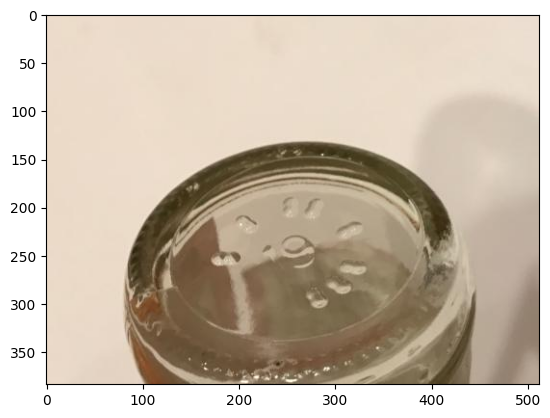

3번째 이미지 예측: plastic, 정답: paper


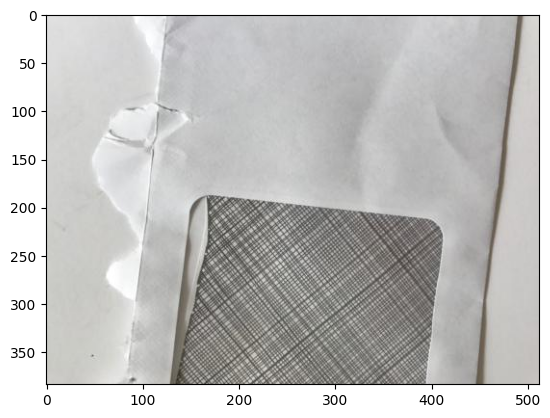

5번째 이미지 예측: metal, 정답: trash


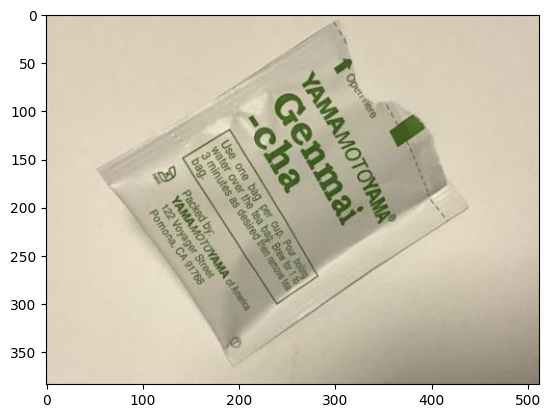

6번째 이미지 예측: plastic, 정답: glass


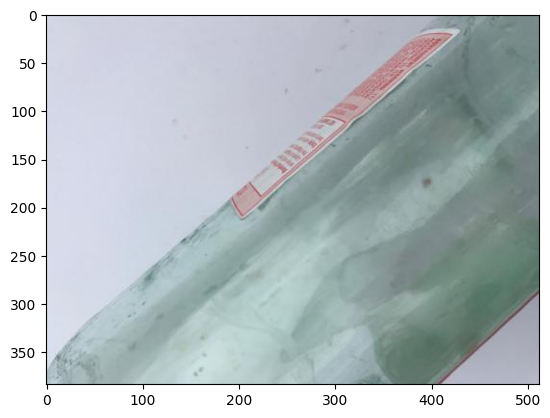

10번째 이미지 예측: trash, 정답: paper


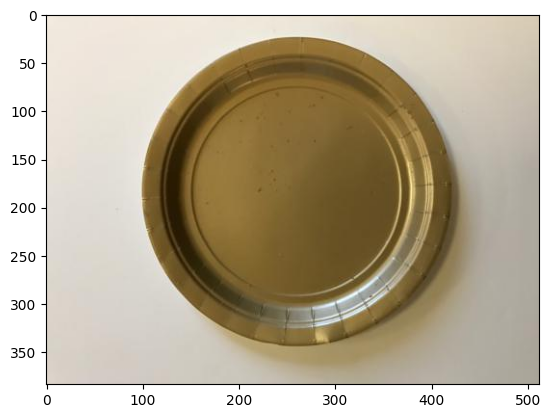

14번째 이미지 예측: trash, 정답: glass


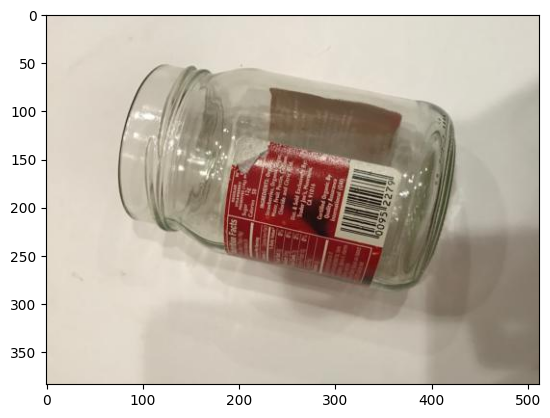

16번째 이미지 예측: metal, 정답: glass


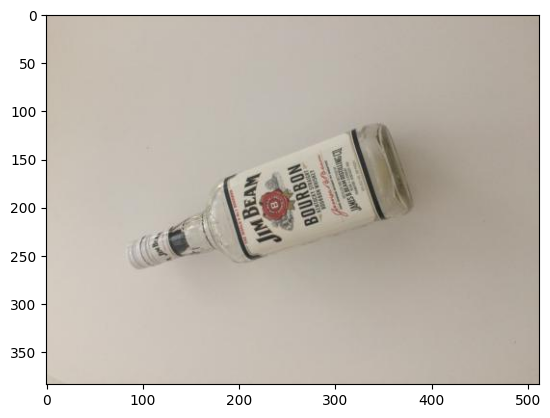

17번째 이미지 예측: plastic, 정답: cardboard


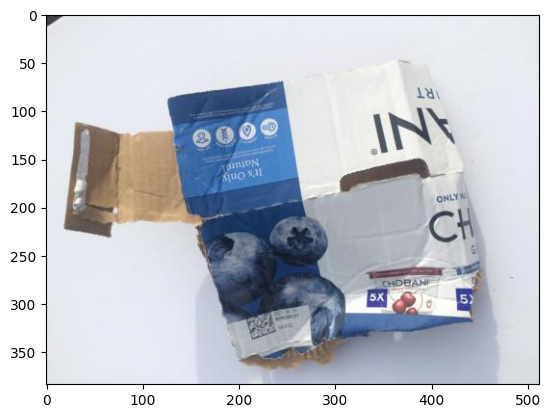

33번째 이미지 예측: glass, 정답: paper


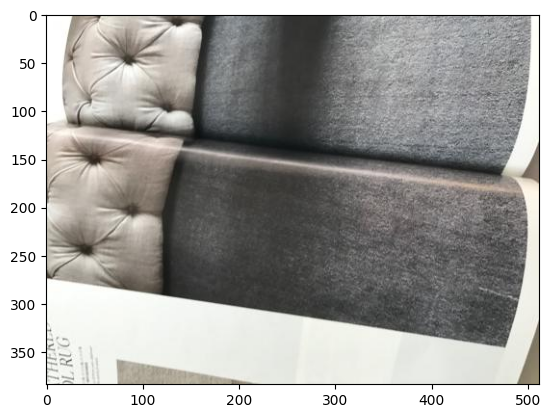

35번째 이미지 예측: plastic, 정답: glass


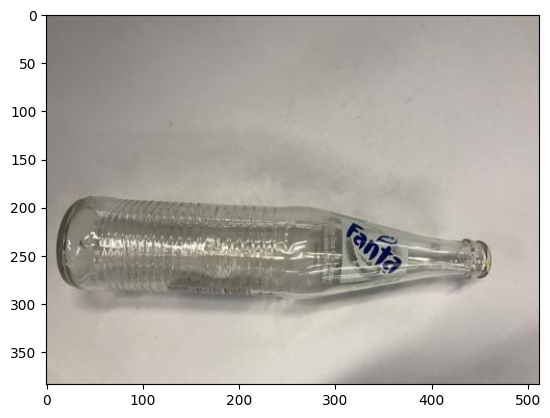

36번째 이미지 예측: metal, 정답: paper


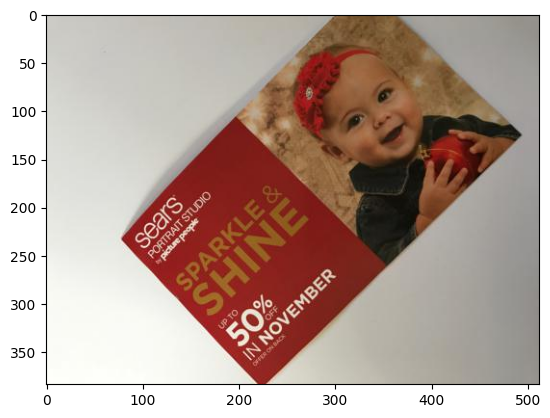

40번째 이미지 예측: trash, 정답: glass


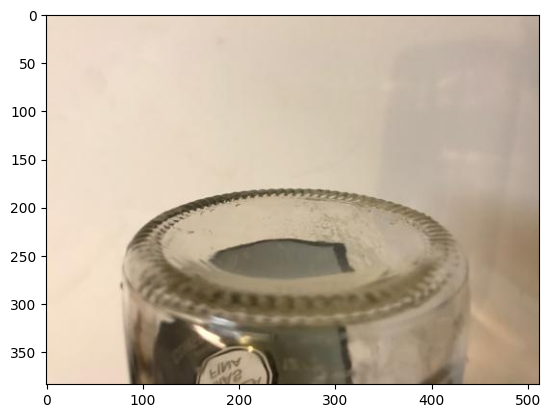

42번째 이미지 예측: cardboard, 정답: plastic


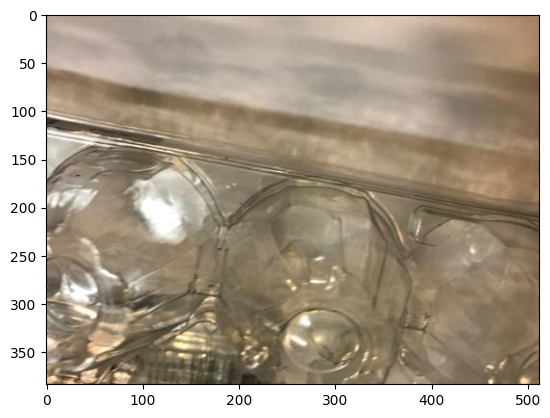

50번째 이미지 예측: cardboard, 정답: paper


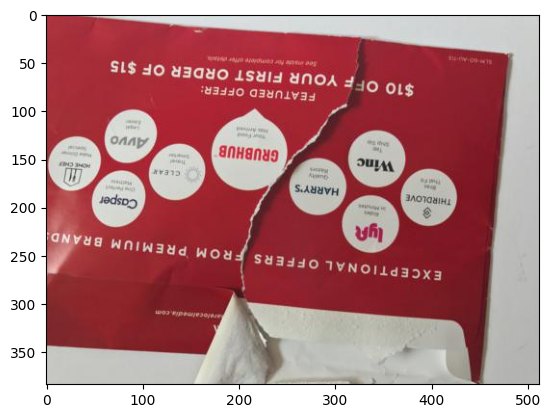

52번째 이미지 예측: metal, 정답: glass


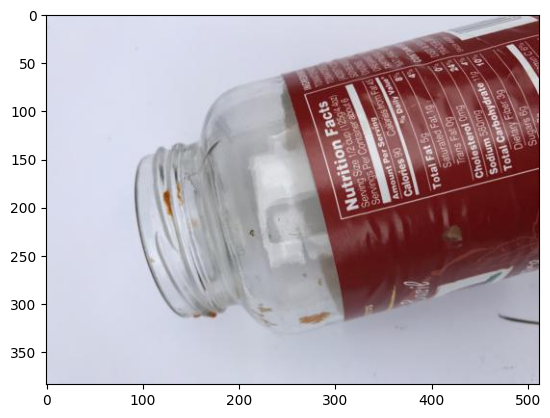

55번째 이미지 예측: trash, 정답: glass


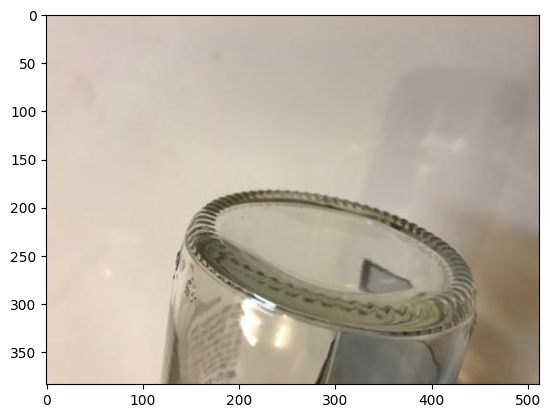

56번째 이미지 예측: plastic, 정답: glass


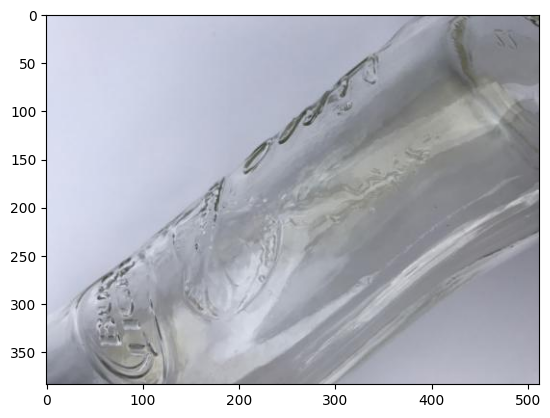

58번째 이미지 예측: glass, 정답: plastic


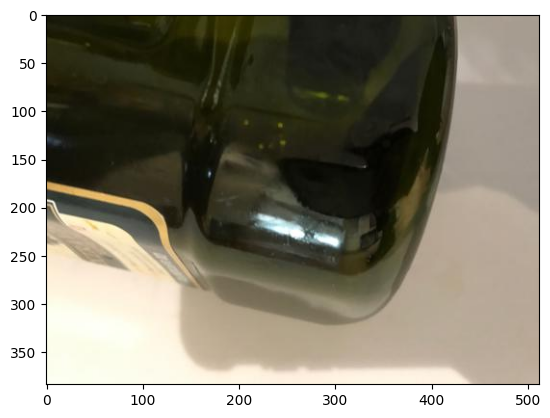

59번째 이미지 예측: metal, 정답: paper


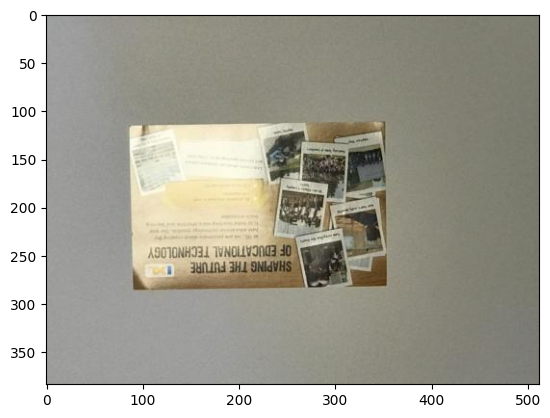

65번째 이미지 예측: glass, 정답: trash


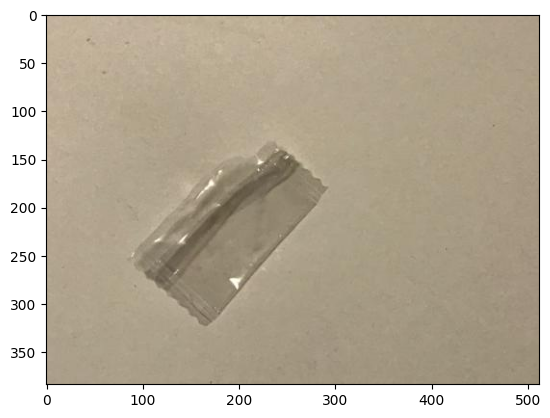

66번째 이미지 예측: metal, 정답: trash


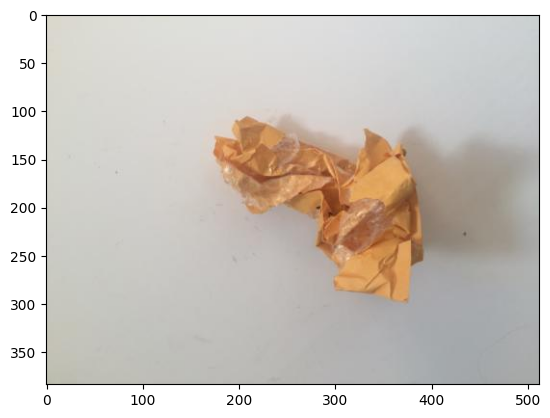

In [26]:
# 틀린 이미지 확인

pred = model.predict(test_images)

pred_labels = np.argmax(pred, axis=1)

wrong_cnt = 0

for i, (p, l) in enumerate(zip(pred_labels, test_labels)):
    if p != l:
        print(f'{i}번째 이미지 예측: {label_dict[p]}, 정답: {label_dict[l]}')
        
        img = Image.open(test_paths[i])
        plt.imshow(img)
        plt.show()
        
        wrong_cnt += 1
        
    if wrong_cnt > 20:
        break